<a href="https://colab.research.google.com/github/KabirSubbiah/Machine-Learning/blob/main/Dependency_Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 ➡️ Assignment 5: Shift-Reduce Dependency Parser
In this assignment, you'll be implementing a dependency parser using the Shift-Reduce algorithm described in lecture on grammars and parsing. In Part 1, you'll implement the basic algorithm, with a dummy "oracle" that just uses the ground-truth labels. Then, you'll train a classifier to act as an actual oracle in Part 2, and evaluate the results of that model in Part 3. Have fun shifting!

# [DO NOT EDIT] Setup

In [1]:
!pip install torch tqdm numpy datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 14.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import random, torch, tqdm

from datasets import load_metric
from google.colab import output
from numpy.typing import NDArray
from torch.optim import Optimizer as TorchOptimizer
from torch.utils.data import DataLoader as TorchDataLoader
from typing import Any, Dict, List, Optional, Tuple

output.enable_custom_widget_manager()
random.seed(1460)
np.random.seed(1460)
torch.manual_seed(1460)

# Part 1: Basic Algorithm with Ground-Truth Oracle

Read through the following sections to understand the setup here, and then complete the TODO sections. We will define several helper functions for you.

## TODO: Download the data

We will be using two files for this assignment: `train.conll` and `test.conll`. You can download [`train.conll` here](https://drive.google.com/file/d/1Yky_NVpL0wKFpA8604TCRbT4CSKidCqK/view?usp=drive_link) and [`test.conll` here](https://drive.google.com/file/d/1J7W_cof5fCroGbC-pLIxUTCvgIDy8ufL/view?usp=drive_link). Drag them into the 'Files' sidebar in this Colab to use them in your code.

## Loading Data
The datasets for this assignment come in a particularly strange format, called CoNLL. We've handled parsing it, but we encourage you to check out the format so that you'll understand it if you ever need to work with it. All that you need to know is that `read_conll` returns a list of dictionaries, where each dictionary encodes a parsed sentence. Each dictionary has a `'words'` key, which maps to a list of words which make up the sentence, and `'heads'` key, which maps to a list of integers, where the value at index `i` is the index of the word that is word `i`'s head. The root word has a head value of `None`.  

So the sentence '1460 is awesome.' would have the words `['1460', 'is', 'awesome', '.']` (yes, the punctuation is included), with heads `[2, 2, None, 2]`. Check out the visual below which illustrates the dependency parse (arrows going out of one word and into another mean that that first word is the head of the other):

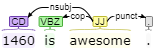

As you can see, 'awesome' is the root word, and its head is hence the value `None`. 'awesome' is also the head of all of the other words, you can see this since the `'heads'` values corresponding to the other words are all `2`, which is the index of the word 'awesome' in the word list!

In [3]:
def read_conll(in_file: str, lowercase: bool = False,
               max_example: Optional[int] = None) -> List[Dict[str, Any]]:
  """
  Function that reads in a CoNLL file and produces example parses.

  Parameters
  ----------
  in_file : str
      file path to a .conll file
  lowercase : bool
      determines whether to lowercase words in the "words" string
  max_example : Optional[int]
      the maximum number of examples to process, or None to process all

  Returns
  -------
  List[Dict[str, Any]]
      a list of examples taken from the .conll file
  """

  examples = []
  with open(in_file) as f:
    word, pos, head, label = [], [], [], []
    for line in f.readlines():
      sp = line.strip().split('\t')
      if len(sp) == 10:
        if '-' not in sp[0]:
          word.append(sp[1].lower() if lowercase else sp[1])
          pos.append(sp[4])
          head.append(int(sp[6]) - 1)
          label.append(sp[7])
      elif len(word) > 0:
        examples.append({'words': word, 'pos': pos, 'heads': head, 'label': label})
        word, pos, head, label = [], [], [], []
        if (max_example is not None) and (len(examples) == max_example):
          break
    if len(word) > 0:
      head[head.index(-1)] = None
      examples.append({'words': word, 'pos': pos, 'heads': head, 'label': label})
  return examples

## (DO NOT EDIT) Ground-Truth Dummy Oracle
This function has been written for you, please do not edit it! It takes the current stack, buffer, root word, as well as the full parse (read from the CoNLL), and returns the ground-truth correct action (arc left, arc right, or shift) to be taken by the Shift-reduce algorithm.

In [4]:
def get_ground_truth_oracle(stack: List[int], buf: List[int],
                            ex: Dict[str, Any]) -> Optional[int]:
  """
  Function that retrieves the best possible action (arc left, arc right, or shift)
  for a given stack, buffer, and ground truth parsing.

  Parameters
  ----------
  stack : List[int]
      the shift-reduce stack
  buf : List[int]
      the shift-reduce buffer
  ex : Dict[str, Any]
      Raw training example dict produced by read_conll()

  Returns
  -------
  Optional[int]: {None, 0, 1, 2}
      action to apply in shift-reduce algorithm
      None -> no actions can be taken
      0 -> arc left
      1 -> arc right
      2 -> shift
  """

  if len(stack) == 1:
      return None if len(buf) == 0 else 2
  elif len(stack) == 2:
      return 1 if len(buf) == 0 else 2

  sf = stack[-1]
  ss = stack[-2]
  hf = ex['heads'][sf]
  hs = ex['heads'][ss]

  if hs == sf:
    return 0
  elif hf == ss and (not any([True for x in buf if ex['heads'][x] == sf])):
    return 1
  else:
    return None if len(buf) == 0 else 2


**VERY IMPORTANT:**


We need to train models using supervised learning to drive our shift-reduce algorithm. To do this, we'll break the parsing of an entire sentence down into steps, called _partial parses_. At each step a classifier will have to decide, given some features, whether to arc left, arc right, or shift. Each partial parse can be labeled with the correct action, and we can train the model to execute partial parses as well as possible!

The input to our model is a set of features, from which the correct partial parse is to be predicted. Our model will use learned word embeddings, and will classify between three classes. The model will have an embedding layer, which can be used to fetch learned embeddings for words, based on their ID. As such, the model takes some number of integers, each less than the length of the vocabulary, as input.

## word_to_id
Since we need to build up a vocabulary when training, and assign an ID/index to each word, we need some functions to handle doing so. We'll first define word_to_id, which when in `is_test=False` mode, both builds a vocabulary as well as returns the IDs of known words. When `is_test=True`, unknown words are not used to expand the vocabulary.

In [5]:
def word_to_id(word: str, vocab: Dict[str, int], is_test: bool = False) -> int:
  """
  Function that converts a string `word` to its corresponding ID in `vocab`.
  If not in testing mode, also adds `word` to vocab.

  Parameters
  ----------
  word : str
      the word in question
  vocab : Dict[str, int]
      vocabulary mapping words to their ID
  is_test : bool
      whether to operate in testing or training mode

  Returns
  -------
  int
      the ID of `word`
  """

  if is_test:
    if word in vocab:
      return vocab[word]
    else:
      return vocab["<UNK>"]

  # otherwise, we're doing train:

  if word in vocab:
    if random.randint(0, 100) <= 5:
      return vocab['<UNK>'] # randomly mask this word for training example, otherwise <UNK> never trained on.
    return vocab[word]

  else:
    n = len(vocab)
    vocab[word] = n
    return n

## TODO: `apply_action`
This is a helper function that applies a given action (arc left, arc right, or shift) to the current stack, buffer, and arcs. It should modify these and return the new stack, buffer, and arcs

In [6]:
from numpy.random.mtrand import noncentral_chisquare
from datasets.utils.py_utils import NonMutableDict
from datasets.info import NonMatchingCachedSizesError
def apply_action(stack: List[int], buf: List[int], arcs: List[Tuple[int, int]],
                 action: int) -> Tuple[List[int], List[int], List[Tuple[int, int]]]:
  """
  Function that applies `action` to the current state. Modifies stack, buf, and
  arcs accordingly and returns the new state. stack, buf, and arcs contain the
  indices of words in an example sentence, where an index of None represents the
  root.

  Parameters
  ----------
  stack : List[int]
      the current shift-reduce stack. stack[-1] is the top of stack, stack[-2] is
      the second item
  buf : List[int]
      the current shift-reduce buffer. buf[0] is the first item in the buffer
  arcs : List[Tuple[int, int]]
      the current arcs produced by shift-reduce (of the form (head idx, word idx))
  action : int
      the action we want to apply
      0 -> arc left
      1 -> arc right
      2 -> shift

  Returns
  -------
  Tuple[List[int], List[int], List[Tuple[int, int]]]
      the updated stack, buffer, and arcs
  """

  head_idx = None
  word_idx = None

  match (action):
    case 0:
      head_idx = stack[-1]
      word_idx = stack.pop(-2)

    case 1:
      head_idx = stack[-2]
      word_idx = stack.pop(-1)

    case 2:
      stack.append(buf.pop(0))

    case _:
      print("Unreachable case reached")

  if (word_idx != None):
    arcs.append((head_idx, word_idx))

  return stack, buf, arcs


## TODO: `is_possible`
`is_possible` returns whether an action (arc or shift) is possible given the current stack and buffer. This will be used in part 2 once we start training an oracle using machine learning.

In [7]:
def is_possible(action: int, stack: List[int], buf: List[int]) -> bool:
  """
  Function that determines if a given action is possible given the current stack
  and buffer state. Remember that stack and buf contain the indices of words in
  an example sentence, where an index of None represents the root. Think carefully
  about this function; it is likely to be a source of errors. Work through the
  example in the slides and try to replicate that logic here. Be particularly
  careful with the root (None). Can anything be the head of root? Should we ever
  perform an arc with the root while there are still words in the buffer?
  Remember that at the beginning of the shift-reduce algorithm, stack and buf
  will look like:
      stack = [None]
      buf = [0, 1, 2, ...]

  Parameters
  ----------
  action : int
      the action we want to know is possible
      0 -> arc left
      1 -> arc right
      2 -> shift
  stack : List[int]
      the shift-reduce stack
  buf : List[int]
      the shift-reduce buffer

  Returns
  -------
  bool
      whether or not the given action is possible
  """

  match (action):
    case 0:
      if stack[-1] == None or stack[-2] == None:
        return False
      return True

    case 1:
      if len(stack) < 2:
        return False

      if len(stack) == 2:
        if len(buf) == 0:
          return True
        else:
          return False

      return True

    case 2:
      if len(buf) == 0:
        return False
      else:
        return True

    case _:
      print("Invalid action given as input")
      return False




## TODO: `get_features`
This is a featurization function - it takes in the stack, buffer, words to be parsed, and vocabulary (as well as an `is_test` flag) and returns a featurization to be passed to the classifier. This featurization should consist of three word IDs to be converted to embeddings.

You may decide how to featurize the stack and buffer such that the classifier executes partial parses with the best results possible, **however our autograder will expect a feature vector of length three**. `stack` and `buf` are both lists of integers that represent indices of strings in the list `words` (with `None` representing the root node). Use these indices to get the corresponding word strings, and then use `word_to_id` to convert words to their IDs. **Note**: for the root use the `'<ROOT>'` token. Remember that our features are in terms of **word ids** in our `vocab`, not **word indices** that the `stack` and `buf` contain!

Keep in mind that you must always output the same number of features. If one of your features is the first word in the buffer, but the buffer is empty, you can provide the ID corresponding to the `'<NW>'` ('no word') token to fill its place!

In [8]:
def get_features(stack: List[int], buf: List[int], words: List[str],
                     vocab: Dict[str, int], is_test: bool = False) -> List[int]:
  """
  Function that takes in the current state (stack, buffer) and produces a set of
  features to be fed into a classifier. Think about what information our
  classifier would need to know in order to predict an optimal action from the
  current state. Hint: you should only need 3 features

  Parameters
  ----------
  stack : List[int]
      the shift-reduce stack
  buf : List[int]
      the shift-reduce buffer
  words : List[str]
      words in the sentence, in order
  vocab : Dict[str, int]
      the word id vocabulary
  is_test : bool
      whether we are in testing mode

  Returns
  -------
  List[int]
      A list of three integers to be fed into the classifier
      Hint: use word_to_id on the items of the data structures
  """
  features = []

  if len(stack) == 1:
    features.append(word_to_id("<ROOT>", vocab, is_test))
    features.append(word_to_id("<NW>", vocab, is_test))

    word3 = "<NW>" if len(buf) == 0 else words[buf[0]]
    features.append(word_to_id(word3, vocab, is_test))

  else:
    word1 = words[stack[-1]]
    features.append(word_to_id(word1, vocab, is_test))

    word2 = "<ROOT>" if stack[-2] == None else words[stack[-2]]
    features.append(word_to_id(word2, vocab, is_test))

    word3 = "<NW>" if len(buf) == 0 else words[buf[0]]
    features.append(word_to_id(word3, vocab, is_test))

  return features


In [9]:
# feel free to test your bow_features here! Modify this example as much as you want
# original: "I prefer the morning flight through Denver ."
example = {'words': "I prefer the morning flight through Denver .".split(" "), 'heads': [1, None, 4, 4, 1, 6, 1, 1]}
fake_vocab = {'<ROOT>': 0, '<UNK>': 1, '<NW>': 2, "I": 3, "prefer": 4, "the": 5, "morning": 6, "flight": 7, "through": 8, "Denver": 9, ".": 10}
# simulate some part of the process, edit stack and buf as you want
stack = [None]                   # stack initialized with root index
buf = [0, 1, 2, 3, 4, 5, 6, 7] # buf initialized with word indices

features = get_features(stack, buf, example['words'], fake_vocab, False)
assert len(features) == 3
print(features)

[0, 2, 3]


## TODO: `oracle_shift_reduce`
This is one of the two implementations of shift reduce in this assignment. It applies the regular shift-reduce algorithm to generate partial parses for training, as well as the correct arcs for a labeled example.

Apply the shift-reduce algorithm, making use of the functions `get_ground_truth_oracle`, `get_features`, and `apply_action` (and possibly more!), in order to both produce a full parse of the input example as well as labeled partial parses. In other words, for each partial parse along the way, we want you to save that state in `featurized_states` with the featurization from your `get_features` function, as well as the "gold" action produced by the ground-truth oracle.

Remember to handle the case where `get_ground_truth_oracle` returns `None`.

In [10]:
from logging import BufferingFormatter
def oracle_shift_reduce(example: Dict[str, Any], vocab: Dict[str, int],
                        is_test: bool = False) -> Tuple[List[List[int]], List[int], List[Tuple[int, int]]]:
  """
  Function that executes the ideal shift reduce algorithm determined by the oracle
  on a single example and returns a set of features and labels to pass into the classifier.
  This function will be called for every example parse to generate our training
  data.

  Parameters
  ----------
  example : Dict[str, Any]
      a training example produced by read_conll
  vocab : Dict[str, int]
      the vocabulary
  is_test : bool
      whether the function is being used to generate training or testing data.

  Returns
  -------
  Tuple[List[List[int]], List[int], List[Tuple[int, int]]]
      featurized states, ground truth actions, and final set of arcs.
      We're not going to need the arcs when generating the data, but they'll
      be useful later on when we assess our model's performance!
  """

  featurized_states = []
  ground_truth_actions = []

  # initialize stack, buffer, and arcs
  stack = [None]
  buf = [i for i in range(len(example['heads']))]
  arcs = []

  while len(buf) > 0 or len(stack) > 1:

    action = get_ground_truth_oracle(stack, buf, example)


    if action != None:
      featurized_states.append(get_features(stack, buf, example['words'], vocab, is_test))
      apply_action(stack, buf, arcs, action) #Remaking of structures can be done with return
      ground_truth_actions.append(action)
    else:
      break
      print(f"While loop broken by None return with {len(buf)} remaining elements in buf and {len(stack)} remaining elements in stack")


  return featurized_states, ground_truth_actions, arcs


# Part 2: Machine Learned Oracle
Above, you implemented a version of shift-reduce that assumed you had a ground-truth oracle. Of course, in practice, you will never have this! So, in order to run your parser on unseen data, you will need to implement another version of the oracle--this time using machine learning!

## `generate_training_data`
First, we need to get training data to train our machine-learned oracle. To do this, we can use our ground truth oracle from above to generate training/testing instances (labeled partial parses) for us to train our classifier on. This essentially entails applying `oracle_shift_reduce` to every example in the raw data.

In [11]:
def generate_training_data(raw_data: List[Dict[str, Any]], vocab: Dict[str, int],
                           is_test: bool = False) -> Tuple[List[List[int]], List[int]]:
  """
  Function that generates training data and labels from a list of examples
  produced by read_conll().

  Parameters
  ----------
  raw_data : List[Dict[str, Any]]
      a list of example parses loaded with read_conll
  vocab : Dict[str, int]
      the vocabulary to use
  is_test : bool
      whether to create testing or training data

  Returns
  -------
  Tuple[List[List[int]], List[int]]
      a set of featurized states and corresponding ground truth actions
  """

  X, Y = [], []

  for i, element in enumerate(raw_data):
    featurized_states, ground_truth_actions, arcs = oracle_shift_reduce(element, vocab, is_test)
    X.extend(featurized_states)
    Y.extend(ground_truth_actions)

  return X, Y

### Dataset objects
Since this assignment uses Pytorch modules as the classifiers for the shift-reduce algorithm, we'll make a dataset child class for our data, such that we can eventually make PyTorch Dataloaders (just as in assignment 4)! This has been implemented for you.


In [12]:
# def of Dataset child obj to use with DataLoader
class SRDataset(torch.utils.data.Dataset):
  def __init__(self, X: List[List[int]], Y: List[int]) -> None:
    """
    Function that initializes fields for the dataset. Anything you need in
    `__init__()` or `__getitem__()` should be saved here by defining any
    number of self.*

    Parameters
    ----------
    X : List[List[int]]
        our featurized data from `generate_training_data()`
    Y : List[int]
        one-hot encoded labels corresponding to each entry in X

    Returns
    -------
    None
    """

    self.X = np.zeros((len(X), len(X[0])), dtype='int32')
    self.Y = np.zeros((len(Y), 3), dtype='float32')
    for i, class_num in enumerate(Y):
      self.X[i] = X[i]
      self.Y[i, class_num] = 1

  def __len__(self) -> int:
    """
    Function that returns the number of training examples.

    Parameters
    ----------
    self : refers to the current object

    Returns
    -------
    int
        the number of entries in X
    """
    return len(self.Y)

  def __getitem__(self, idx: int) -> Dict[str, NDArray[Any]]:
    """
    Function that defines how to retrieve an entry and a label from the data given
    and index.

    Parameters
    ----------
    idx : int
        the index of an example in X or Y
    Returns
    -------
    Dict[str, NDArray[Any]]
        a dictionary defining the example and corresponding label described by
        index `idx`
    """
    return {'inputs': self.X[idx], 'targets': self.Y[idx]}

### Training Function

Here we define our function for training the model. This has been implemented for you

In [13]:
def train(model: torch.nn.Module, dataloader: TorchDataLoader, epochs: int,
          optimizer: TorchOptimizer, metric_names: List[str]) -> None:
  """
  Function that trains our classifier.

  Parameters
  ----------
  model : torch.nn.Module
      the classifier we want to train
  dataloader : torch.utils.data.DataLoader
      the dataloader containing our training data
  epochs : int
      number of epochs to train the model
  optimizer : torch.optim.Optimizer
      the optimizer to user for training
  metric_names : List[str]
      list of metric names to compute

  Returns
  -------
  None
  """
  model.train()
  loss_func = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    print(f"epoch {epoch}")
    progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

    metrics = [load_metric(x) for x in metric_names]

    for batch in dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}

      outputs = model(**batch)

      loss = loss_func(outputs['output'], outputs['labels'])
      loss.backward()

      predictions = torch.argmax(outputs['output'], dim=1)
      references = torch.argmax(outputs['labels'], dim=-1)

      for metric in metrics:
        metric.add_batch(predictions=predictions, references=references)

      optimizer.step()
      optimizer.zero_grad()
      progress_bar.update(1)

    for metric in metrics:
      print(metric.compute())


## TODO: `SRClassifier`
Now, let's design a simple neural classifier to train on the partial parse classification task.

It needs to have an embedding layer of size `vocab_size`, with embedding dimension of your choosing. After converting your word ids to embeddings, make sure you concatenate them together into one long vector so that they play nicely with your linear layers. We've provided a `num_features` argument such that you can make your classifier work with any number of input word IDs (which will make your life easier if you use it). Then, it's going to need several linear layers and activation functions (two hidden layers should be enough), eventually ending with three output classes (corresponding to our three possible actions). In `forward`, we need to specify how the model will be applied to input features.

PyTorch documentation will be very helpful here! You should look at the `torch.nn.Embedding` layer for word embeddings, you may find the examples helpful in figuring out what to do with its output.

In [14]:
# model that takes input in format given by SRDataset
class SRClassifier(torch.nn.Module):
  def __init__(self, vocab_size: int, num_features: int) -> None:
    """
    Function that initializes fields for this model. This is where you can
    your model's architecture.

    Parameters
    ----------
    vocab_size : int
        the number of words in our vocabulary
    num_features : int
        the number of features for each training example (same as length of the
        list returned by `get_features()`)

    Returns
    -------
    None
    """
    print(f"Vocab size: {vocab_size}")
    super(SRClassifier, self).__init__()

    self.embedding = torch.nn.Embedding(vocab_size, 100)

    self.linear1 = torch.nn.Linear(num_features*100, 100)
    self.relu1 = torch.nn.ReLU()

    self.linear2 = torch.nn.Linear(100, 20)
    self.relu2 = torch.nn.ReLU()

    self.linear3 = torch.nn.Linear(20, num_features)


  def forward(self, inputs: torch.IntTensor,
              targets: Optional[torch.IntTensor] = None) -> Dict[str, torch.FloatTensor | torch.IntTensor]: # notice that the arg names need to match SRDataset.__getitem__() keys
    """
    Function that defines the forward pass for this model.

    Parameters
    ----------
    inputs : torch.IntTensor
        a tensor passed into our model. When training/testing, the torch
        dataloader automatically casts our numpy arrays to tensors.
    targets : Optional[torch.IntTensor]
        a tensor representing labels for each training example in `inputs`. If
        not training, this parameter can be None.

    Returns
    -------
    Dict[str, torch.FloatTensor | torch.IntTensor]
        a dictionary containing our model's output and corresponding labels.
    """
    embed = self.embedding(inputs)

    lin_1 = self.linear1(embed.view(embed.size(0), -1))
    lin_2 = self.linear2(self.relu1(lin_1))
    outputs = self.linear3(self.relu2(lin_2))

    return {'output': outputs, 'labels': targets}

## TODO: Training the classifier
Let's initialize some required data that will be used in training. This includes our vocabulary, which will be built when loading training data. By default, the vocabulary should map `'<UNK>'`, `'<NW>'`, and `'<ROOT>'` to start.

In [15]:
vocabulary = {'<ROOT>': 0, '<UNK>': 1, '<NW>': 2}

We load the training data using `read_conll`, generate training data using `generate_training_data` and instantiate a `SRDataset` object with them. Finally, create a dataloader with the `SRDataset` object - the batch size can be very high, but if you somehow run out of memory, you should decrease it. *Nothing TODO here!*

In [16]:
raw_training_data = read_conll('train.conll')

X_train, Y_train = generate_training_data(raw_training_data, vocabulary)

train_dataset = SRDataset(X_train, Y_train)
train_dataloader = TorchDataLoader(train_dataset, batch_size=1024)


In [17]:
# At this point, each partial parse should be a n-tuple of integers.
print(X_train[:10])
print(Y_train[:10])

[[0, 2, 3], [3, 0, 4], [4, 3, 5], [5, 4, 6], [6, 5, 7], [7, 6, 8], [7, 5, 8], [7, 4, 8], [7, 3, 8], [7, 1, 8]]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 2]


Next, let's instantiate our classifier and set up training hyperparameters and the optimizer.

In [18]:
# setting up the classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRClassifier(len(vocabulary), 3) # instantiate classifier
print(model)

# hyperparameters:
# TODO: Choose hyperparameters
# Note: Maybe start with ~4-5 epochs, it depends on your featurization - you'll likely have to play around with it
epochs = 5

# optimizer, device, and such
# AdamW works well... Try an initial learning rate of 5e-3. Again, you may find that tuning this gives
# you better performance!
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
model.to(device)

metrics = ['accuracy']

train(model, train_dataloader, epochs, optimizer, metrics)

Vocab size: 29162
SRClassifier(
  (embedding): Embedding(29162, 100)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=100, out_features=20, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=20, out_features=3, bias=True)
)
epoch 0


  0%|          | 0/853 [00:00<?, ?it/s]

<ipython-input-13-d61de69313c3>:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics = [load_metric(x) for x in metric_names]


{'accuracy': 0.8004024933500351}
epoch 1


  0%|          | 0/853 [00:00<?, ?it/s]

{'accuracy': 0.8624864049619454}
epoch 2


  0%|          | 0/853 [00:00<?, ?it/s]

{'accuracy': 0.8852618899996676}
epoch 3


  0%|          | 0/853 [00:00<?, ?it/s]

{'accuracy': 0.9007335876804029}
epoch 4


  0%|          | 0/853 [00:00<?, ?it/s]

{'accuracy': 0.9127579619075342}


## Evaluating the classifier
We can evaluate the classifer to get an idea of its accuracy before we use it as an oracle in the shift-reduce algorithm. First, load the testing data and generate the testing instances, afterwhich you should instantiate `SRDataset` and `DataLoader` objects similarly to when training. REMEMBER: Now that we're testing, we don't want to augment the vocabulary, thus we pass `is_test=True` to `generate_training_data`.

In [19]:
test_data = read_conll('test.conll')

X_test, Y_test = generate_training_data(test_data, vocabulary, is_test=True) # is_test is true here!

test_dataset = SRDataset(X_test, Y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

In [20]:
def evaluate(model: torch.nn.Module, dataloader: TorchDataLoader,
             metric_names: List[str]) -> None:
  """
  Function that evaluates a trained model.

  Parameters
  ----------
  model : torch.nn.Module
      the 1st param name `first`
  dataloader : torch.utils.data.DataLoader
      the dataloader containing our testing data
  metric_names : List[str]
      a list of metric names to compute

  Returns
  -------
  None
  """
  model.eval()
  metrics = [load_metric(metric) for metric in metric_names]

  print("evaluation: ")
  progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

  for batch in dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    predictions = torch.argmax(outputs['output'], dim=1)
    references = torch.argmax(outputs['labels'], dim=-1)

    for metric in metrics:
      metric.add_batch(predictions=predictions, references=references)

    progress_bar.update(1)

  for metric in metrics:
    print(metric.compute())

We can evaluate the model to assess its performance at correctly executing partial parses!

In [21]:
metrics = ['accuracy']
evaluate(model, test_dataloader, metrics)

evaluation: 


  0%|          | 0/443 [00:00<?, ?it/s]

{'accuracy': 0.8768398574000211}


# Part 3: Evaluation and Visualization

Ok, so we've evaluated the classifier, and it seems to perform well. However, the accuracy score it recieved above doesn't quite represent the performance of our algorithm overall when it is actually applied. To measure this, we use something called UAS - **Unlabeled Attachment Score**. UAS measures the proportion of correctly assigned heads in a full parse. So far, we've only really been considering partial parses. Since a full parse requires sequentially executing partial parses, if one partial parse is wrong, it could influence future partial parses and lead to further incorrect partial parses. Thus, we'd expect our UAS to be *worse* than the accuracy we previously saw, which is more reflective of how well the algorithm is actually doing.

## TODO: `get_action`

This function takes in the classifier's prediction (in the form of a tensor) and outputs the corresponding action. Make sure to only return an action that is possible given the current stack and buffer state.

In [22]:
def get_action(pred: torch.DoubleTensor, stack: List[int],
               buf: List[int]) -> Optional[int]:
  """
  Function that takes a prediction (tensor) and finds the highest probability
  action that is possible.

  Parameters
  ----------
  pred : torch.DoubleTensor
      our classifier's prediction, the "output" field of a torch.nn.Module (such
      as our model)
  stack : List[int]
      the shift-reduce stack
  buf : List[int]
      the shift-reduce buffer

  Returns
  -------
  Optional[int]: {None, 0, 1, 2}
      the predicted action.
      None -> no actions can be taken
      0 -> arc left
      1 -> arc right
      2 -> shift
  """

  for i in pred.argsort(descending=True)[0]:
    if (is_possible(i.item(), stack, buf)):
      return i.item()
  return None


## TODO: `model_shift_reduce`
Here, we define a version of shift-reduce that consults an SRClassifier, rather than the oracle from Part 1, in order to determine which actions to apply. Use as many helpers from above as needed to write this.

In [23]:
def model_shift_reduce(model: torch.nn.Module, example: Dict[str, Any],
                       vocab: Dict[str, int]) -> List[Tuple[int, int]]:
  """
  Function that uses our trained classifier to execute the shift-reduce algorithm
  and returns the final list of arcs. Note that you will have to cast the output
  of `get_features()` to a tensor and load it onto the GPU. You can do this using
  `torch.tensor(...).to(device)` or `torch.tensor(..., device=device)`. Note that
  `device` was defined a few cells up, when we instantiated our model.

  Parameters
  ----------
  model : torch.nn.Module
      our trained classifier to use for shift-reduce
  example : Dict[str, Any]
      a training example produced by read_conll
  vocab : Dict[str, int]
      our vocabulary

  Returns
  -------
  List[Tuple[int, int]]
      the arcs of the dependency parse tree
  """

  # initialize stack, buffer, and arcs
  stack = [None]
  buf = [i for i in range(len(example['heads']))]
  arcs = []

  while len(buf) > 0 or len(stack) > 1:
    features = torch.tensor([get_features(stack, buf, example['words'], vocab, True)], device=device)
    action = get_action(model(features)['output'], stack, buf)

    if action != None:
      stack, bufs, arcs = apply_action(stack, buf, arcs, action) #Remaking of structures can be done with return
    else:
      break
      print(f"While loop broken by None return with {len(buf)} remaining elements in buf and {len(stack)} remaining elements in stack")

  return arcs


## TODO: `evaluate_UAS`
Now that we can directly compare the true parse to the model's parse, we can tackle evaluating the UAS. To evaluate UAS, we first compute both the correct and predicted parses for each testing phrase and then find the number of arcs in common divided by the number of total arcs. Then, we average these scores across all testing phrases and output the result as UAS of the model on the testing set.

$$n: \text{the total number of example parses}$$
$$M_i: \text{the set of our model's predicted arcs for example }i$$
$$O_i: \text{the set of the oracle's predicted arcs for example }i$$
$$\text{UAS} = \frac{1}{n} \sum_{i=1}^n \frac{|M_i \cap O_i|}{|O_i|}$$

In [24]:
def evaluate_UAS(model: torch.nn.Module, test_examples: List[Dict[str, Any]],
                 vocab: Dict[str, int]) -> float:
  """
  Function that calculates UAS.

  Parameters
  ----------
  model : torch.nn.Module
      our trained classifier
  test_examples : List[Dict[str, Any]]
      test examples loaded with read_conll
  vocab : Dict[str, int]
      our word2id vocabulary

  Returns
  -------
  float
      UAS of the classifier on test_examples
  """
  cum_sum = 0.00
  for element in test_examples:
    featurized_states, ground_truth_actions, oracle_arcs = oracle_shift_reduce(element, vocab, True)
    model_arcs = set(model_shift_reduce(model, element, vocab))
    intersection = len(set(oracle_arcs).intersection(model_arcs))

    cum_sum += intersection/len(oracle_arcs)

  return cum_sum/len(test_examples)

### Baseline UAS
Of course, we'd have no idea if our model was useful if we didn't evaluate a baseline model too. The baseline model should output something of the same format as the `SRClassifier`, except it just outputs a tensor with randomly ordered values.

In [25]:
# model that takes input in format given by SRDataset
class SRBaseline(torch.nn.Module):
    def __init__(self) -> None:
        super(SRBaseline, self).__init__()

    def forward(self, inputs: Any) -> Dict[str, torch.Tensor]:
        return {'output': torch.randperm(3)[None, :]}

## TODO: Final Scoring
Evaluate the baseline UAS and compare it to that of our model. For this function, directly use the CoNLL dataset as the argument to `test_examples`, not the dataloader we had used for training.

In [26]:
model_uas = evaluate_UAS(model, test_data, vocabulary)
baseline_model = SRBaseline()
baseline_uas = evaluate_UAS(baseline_model, test_data, vocabulary)
print(f"Model UAS: {model_uas}, baseline: {baseline_uas}")

Model UAS: 0.6866029050465488, baseline: 0.1371216970772357


The model should be over three times better than the baseline. For full credit, your model should have a UAS of over 65%, so you may need to make adjustments to your model, featurization, and hyperparameters in order to improve your score. If you submit with a UAS of under 65%, you'll recieve partial credit.

# Part 4: Conceptual
Let's explore some of the parses visually. The following functions deal with reformating and displaying dependency parses. You'll only need to use `display_parse`, check its signature. Additionally, you'll be asked to compare the parses that your model creates with real parses.

## Helpers and examples

In [27]:
import spacy
from spacy import displacy
from spacy.displacy.render import DependencyRenderer
from IPython.core.display import display, HTML

def reformat_dep(arcs: List[Tuple[int, int]], words: List[str]) -> Tuple[List[str], List[int]]:
  """
  Function that takes in a set of arcs and produces a list of heads,
  in the same format we described at the beginning.

  Parameters
  ----------
  arcs : List[Tuple[int, int]]
      a list of arcs returned by model_shift_reduce
  words : List[str]
      a list of words from a testing example

  Returns
  -------
  Tuple[List[str], List[int]]
      the words parameters and the list of heads
  """
  heads = list(range(len(words)))
  for arc in arcs:
    heads[arc[1]] = arc[0]
  return words, heads

def parse_for_displacy(doc: List[str], heads: List[int]) -> Dict[str, Any]:
  """
  Function that takes in a sentence and a list of heads and reformats them into
  something that can be rendered using displacy.

  Parameters
  ----------
  doc : List[str]
      a list of words in a sentence
  heads : List[int]
      a list of indices indexing `doc` that represent the head of each word

  Returns
  -------
  Dict[str, Any]
      the parsed sentence in a format friendly to displacy
  """
  #doc = ['word1', 'word2', ...]
  #heads = [idx_of_head_of_word1, idx_of_head_of_word2, ...]
  settings = {
      "lang": 'en',
      "direction": 'ltr',
  }
  words = [
      {
          "text": w,#w.text,
          "tag": '',#w.tag_ if fine_grained else w.pos_,
          "lemma": w#w.lemma_ if add_lemma else None,
      }
      for w in doc
  ]
  arcs = []
  for i,word in enumerate(doc):
      if heads[i] == None:
        continue
      if i < heads[i]:
          arcs.append(
              {"start": i, "end": heads[i], "label": '', "dir": "left"}
          )
      elif i > heads[i]:
          arcs.append(
              {
                  "start": heads[i],
                  "end": i,
                  "label": '',
                  "dir": "right",
              }
          )
  return {"words": words, "arcs": arcs, "settings": settings}

def display_parse(arcs: List[Tuple[int, int]], words: List[str]) -> None:
  """
  Function that renders and displays a parsed sentence.

  Parameters
  ----------
  arcs : List[Tuple[int, int]]
      the final set of arcs returned by our shift-reduce algorithm
  words : List[str]
      the words that `arcs` connects

  Returns
  -------
  None
  """
  parsed=[parse_for_displacy(*reformat_dep(arcs, words))]
  renderer = DependencyRenderer()
  html = renderer.render(parsed, page=False, minify=False).strip()
  display(HTML('<span class="tex2jax_ignore">{}</span>'.format(html)))

Here's an example, where we try to parse the sentence "I prefer the morning flight through Denver.". Note that punctuation is treated as its own token here. Below is a brief summary of how you need to format punctuation and contractions such that they're in the same format as the training/testing data we used previously:

`"weren't" -> ["were", "n't"]`

`"Stock Market's" -> ["Stock", "Market", "'s"]`

`["'quoted text'"] -> ["``", "quoted", "text", "''"]`

`["22%"] -> ["22", "%"]`

`["$15"] -> ["$", "15"]`

Feel free to download `train.conll` or `test.conll` and take a peek at how the examples are tokenized.

Additionally, we didn't do any lowercasing on the dataset, since it actually slightly harms performance on this task (think about why it might), so also don't do lowercasing when trying out your own sentences (see that "Denver" stays capitalized).

In [28]:
example = {'words': "I prefer the morning flight through Denver .".split(" "), 'heads': [1, None, 4, 4, 1, 6, 4, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


## TODO: Conceptual question

Now, come up with some of your own examples and visualize them! Try to find some scenarios where the parses your model produces aren't as accurate, **and comment on them**. A great tool to generate the correct parses is [this site](https://corenlp.run/) by CoreNLP. Select only 'dependency parse' in the annotation selection box, type in your examples, and hit 'Submit' to see the parses!

Recall the format of the head list: The entry with value `None` is the root word, and the entries at all other words are the index of their respective heads! In the example above, 'prefer' is the root word (thus has `None` as its head), so any word in the word list who's head is 'prefer' has a `1` as its head value (since 'prefer' is the second word), and so on. You'll need to encode the correct parse given by CoreNLP into the head list, so make sure to triple-check that you got it right.

If you take a look at the kinds of words frequently used in the training dataset (there's a theme, take a look), it may explain some behaviors.

TODO: Fill me in!!

In [29]:
example = {'words': "Player bats till India wins .".split(" "), 'heads': [1, None, 4, 4, 1, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


I used this example because the model may not recognize bats as a verb (due to training data inadequacies perhaps). This throws off the model because:
1. It assumes bats is the noun and thus makes it the parent of wins.
2. It assumes wins is the only verb and thus makes it the parent of the full stop that terminates the sentence.

This issue would likely be resolved by using a more diverse and expansive training dataset.


In [30]:
example = {'words': "product Marketing , a complex subject .".split(" "), 'heads': [1, None, 1, 5, 5, 1, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


I wanted to try an example with an incorrect capitalisation and the results were unexpected. The actual parse makes marketing the parent of a lot of the sentence. However, our predicted parse places great importance on complex, which is definitely incorrect.

I was keen to understand how much of this had to do with capitalisation so I ran the below test.

(Explanation continued)

In [31]:
example = {'words': "product marketing , a complex subject .".split(" "), 'heads': [1, None, 1, 5, 5, 1, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


From this, we can see that the capitalisation is responsible for some of the stress that is placed on complex, but not all of it. The rest could be because perhaps the model recognizes complex as a noun or is unfamiliar with this structure of a sentence fragment.

In [32]:
example = {'words': "There is a great deal of blatant corruption in the present government .".split(" "), 'heads': [1, None, 4, 4, 1, 4, 7, 5, 7, 11, 11, 8, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


I used this example because I wanted to see how the model performed on a longer sentence where some of the words (present, deal) have multiple meanings (and word types) depending on the context they are used in. Grammatically, this sentence is correct; yet, the model makes significant mistakes. Such an example, due to the length and complexity, is somewhat hard to analyze, interpret and break down into specific factors. Perhaps we should try with a simpler version to understand the model's behaviour better.

In [33]:
example = {'words': "There is blatant corruption in the present government .".split(" "), 'heads': [1, None, 3, 1, 3, 7, 7, 4, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


We have tried to cut down on input sentence length while reducing complexity (deal is not included). However, we have still included one complex word (present), which throws off the model in this case. Present is simply describing the government, but our model interprets it as a verb/noun and thus makes it the head of the surrounding words. Let us try without this word as well.

In [34]:
example = {'words': "There is blatant corruption in the government .".split(" "), 'heads': [1, None, 3, 1, 3, 6, 4, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example['words'])
print("Actual parse:")
display_parse(true_arcs, example['words'])

Predicted parse:


Actual parse:


Our model performs slightly better but still makes some important mistakes. We can observe that, even after reducing sentence length and complexity, it is difficult to interpret and make conclusions about this model's behaviour. In this example, one could perhaps say that inadequacies in the training dataset lead to the model undervaluing commons verbs like is and in. Or perhaps that the model does not place enough importance on sequential relationships. However, it is difficult to make any conclusive observations unless we intervene at the attention/neuron level.

# Submission

Download this notebook as a .ipynb and .py file and submit it to Gradescope. Before doing so, additionally paste a link to your notebook in the text cell below.

**LINK TO THIS NOTEBOOK:** [...](https://colab.research.google.com/drive/1YUE_wAURnMKB1SKctWKRKFvme7T2RdbV#scrollTo=lOS5mPpUIF4_)